In [1]:
from IPython.display import display
from IPython.display import IFrame

import base64
import pandas as pd
import pm4py

def view_html(filename: str):
  display(IFrame(src="data:text/html;base64," + base64.b64encode(open(filename, "rb").read()).decode("ascii"), width=1000, height=1000))

### Read the log

In [2]:
log = pm4py.read_xes("Sepsis.xes", variant="iterparse20")
log.head(5)

,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,concept:name,...,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,case:concept:name,Leucocytes,CRP,LacticAcid
0,True,A,True,True,True,True,True,True,True,ER Registration,...,True,complete,A,False,True,True,A,NaN,NaN,NaN
1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,complete,NaN,NaN,NaN,NaN,A,9.6,NaN,NaN
2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN
3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2
4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN


## Preliminary analysis

In [3]:
log.dtypes

InfectionSuspected                        object
org:group                                 object
DiagnosticBlood                           object
DisfuncOrg                                object
SIRSCritTachypnea                         object
Hypotensie                                object
SIRSCritHeartRate                         object
Infusion                                  object
DiagnosticArtAstrup                       object
concept:name                              object
Age                                      float64
DiagnosticIC                              object
DiagnosticSputum                          object
DiagnosticLiquor                          object
DiagnosticOther                           object
SIRSCriteria2OrMore                       object
DiagnosticXthorax                         object
SIRSCritTemperature                       object
time:timestamp               datetime64[ns, UTC]
DiagnosticUrinaryCulture                  object
SIRSCritLeucos      

In [4]:
nominal_features = log.columns[log.dtypes == object]
for feature in nominal_features:
  log[feature] = log[feature].astype("string")
log["Age"] = log["Age"].astype("Int32")


In [5]:
n_traces = len(log["case:concept:name"].unique())
print(f"# traces: {n_traces}")

# traces: 1050


### The relative frequency of activities

In [6]:
activity_attribute = "concept:name"
activities = log.groupby(activity_attribute)[activity_attribute].count()
activities.sort_values(ascending=False, inplace=True)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
activities / activities.sum() * 100

concept:name
Leucocytes         22.24
CRP                21.44
LacticAcid          9.64
Admission NC        7.77
ER Triage           6.92
ER Registration     6.90
ER Sepsis Triage    6.89
IV Antibiotics      5.41
IV Liquid           4.95
Release A           4.41
Return ER           1.93
Admission IC        0.77
Release B           0.37
Release C           0.16
Release D           0.16
Release E           0.04
Name: concept:name, dtype: float64

### Start and end activities

In [7]:
start_activities = pm4py.stats.get_start_activities(log)
end_activities = pm4py.stats.get_end_activities(log)
print("Start activities:")
display(start_activities)
print("End activities:")
display(end_activities)

Start activities:


{'ER Registration': 995,
 'IV Liquid': 14,
 'ER Triage': 6,
 'CRP': 10,
 'ER Sepsis Triage': 7,
 'Leucocytes': 18}

End activities:


{'Release A': 393,
 'Return ER': 291,
 'IV Antibiotics': 87,
 'Release B': 55,
 'ER Sepsis Triage': 49,
 'Leucocytes': 44,
 'IV Liquid': 12,
 'Release C': 19,
 'CRP': 41,
 'LacticAcid': 24,
 'Release D': 14,
 'Admission NC': 14,
 'Release E': 5,
 'ER Triage': 2}

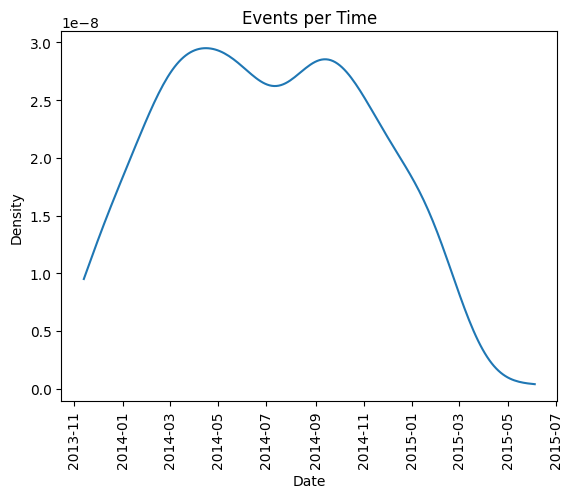

''

In [8]:
pm4py.view_events_per_time_graph(log)
pm4py.vis.save_vis_events_per_time_graph(log, "images/events_per_time.pdf")

### Weekday events distribution plot

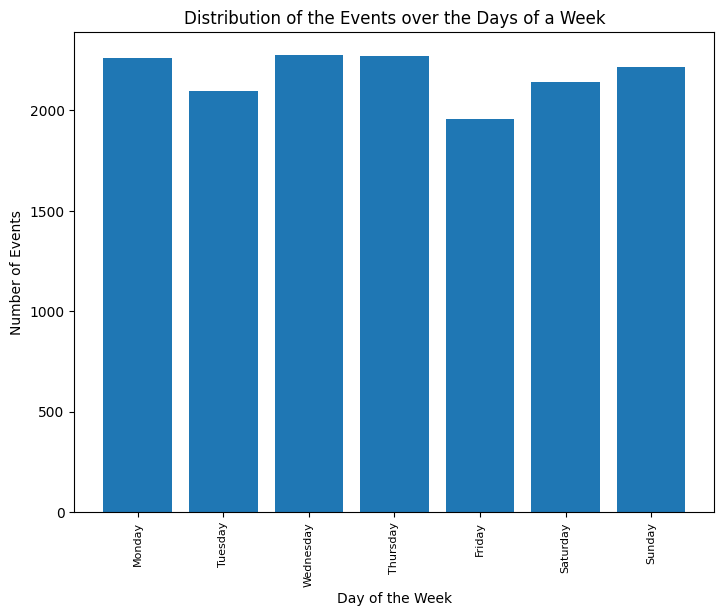

''

In [9]:
pm4py.view_events_distribution_graph(log)
pm4py.save_vis_events_distribution_graph(log, "images/events_distribution.pdf")

### Distribution of events over hours

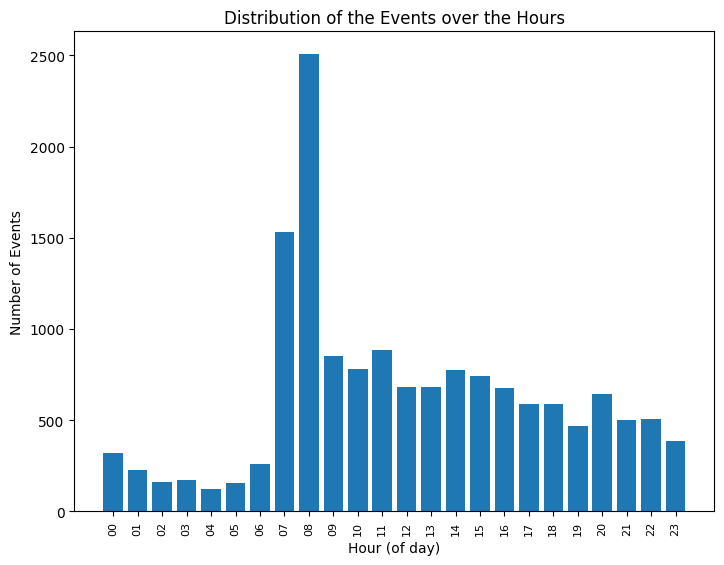

''

In [10]:
pm4py.view_events_distribution_graph(log, distr_type="hours")
pm4py.save_vis_events_distribution_graph(log, distr_type="hours", file_path="images/events_distribution_hours.pdf")

### Distribution of events over months

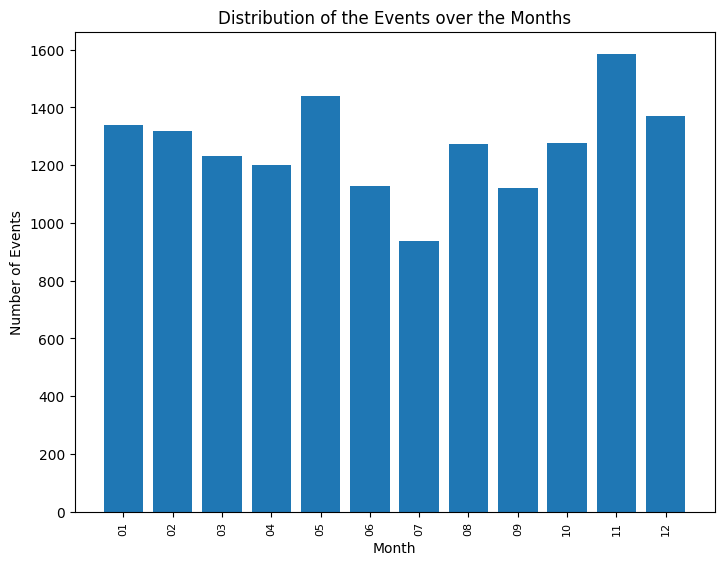

''

In [11]:
pm4py.view_events_distribution_graph(log, distr_type="months")
pm4py.save_vis_events_distribution_graph(log, distr_type="months", file_path="images/events_distribution_months.pdf")

### Case duration plot

In [12]:
pm4py.vis.save_vis_case_duration_graph(log, "images/case_duration.pdf")

''

### Most common process variants

In [13]:
variants = pm4py.get_variants(log[log["lifecycle:transition"] != "start"])
common_variants = pd.DataFrame(variants.items(), columns=["variant", "count"]).sort_values("count", ascending=False)
common_variants["percentile"] = common_variants["count"] / common_variants["count"].sum() * 100
pd.set_option("display.max_colwidth", None)
common_variants.head(10)[["variant", "count", "percentile"]]

,variant,count,percentile
21,"(ER Registration, ER Triage, ER Sepsis Triage)",35,3.33
24,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP)",24,2.29
95,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes)",22,2.10
3,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, LacticAcid, Leucocytes, IV Liquid, IV Antibiotics)",13,1.24
36,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid)",11,1.05
139,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid, IV Liquid, IV Antibiotics)",9,0.86
1,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, LacticAcid, CRP, IV Liquid, IV Antibiotics)",7,0.67
83,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes, LacticAcid, IV Liquid, IV Antibiotics)",5,0.48
125,"(ER Registration, ER Triage, CRP, Leucocytes, ER Sepsis Triage)",5,0.48
158,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, Admission NC, Release A)",5,0.48


In [14]:
resource_attribute = "org:group"
activities_resources = log.groupby(activity_attribute)[resource_attribute].unique().agg(", ".join)
display(pd.merge(activities, activities_resources, left_index=True, right_index=True)["org:group"])

concept:name
Leucocytes                                                                   B
CRP                                                                          B
LacticAcid                                                                   B
Admission NC        D, F, G, H, I, J, K, M, N, O, Q, R, S, T, U, V, P, X, W, Y
ER Triage                                                                    C
ER Registration                                                           A, L
ER Sepsis Triage                                                          A, L
IV Antibiotics                                                            A, L
IV Liquid                                                                 A, L
Release A                                                                    E
Return ER                                                                    ?
Admission IC                                                        J, P, K, W
Release B                              

In [15]:
print("Activities at the beginning of the process:")
display(log[log[activity_attribute].isin(start_activities)][activity_attribute].unique())

print("Activities at the end of the process:")
display(log[log[activity_attribute].isin(end_activities)][activity_attribute].unique())

Activities at the beginning of the process:


<StringArray>
[ 'ER Registration',       'Leucocytes',              'CRP',
        'ER Triage', 'ER Sepsis Triage',        'IV Liquid']
Length: 6, dtype: string

Activities at the end of the process:


<StringArray>
[      'Leucocytes',              'CRP',       'LacticAcid',
        'ER Triage', 'ER Sepsis Triage',        'IV Liquid',
   'IV Antibiotics',     'Admission NC',        'Release A',
        'Return ER',        'Release B',        'Release C',
        'Release D',        'Release E']
Length: 14, dtype: string

## Extended analysis

We will select cases with a valid beginning and end activities. According to the domain knowledge, the valid start activity is ER Registration, and the end activities are Releases and Return ER.

In [16]:
initial_log_len = len(log)

valid_star_activity = {"ER Registration"}
valid_end_activities = {"Release A", "Release B", "Release C", "Release D", "Release E", "Return ER"}

log = pm4py.filter_start_activities(log, valid_star_activity)
log = pm4py.filter_end_activities(log, valid_end_activities)

print("Filtered log length:", len(log))
print((initial_log_len - len(log))/initial_log_len)
n_traces = len(log["case:concept:name"].unique())
print(f"Remaining traces: {n_traces}")

Filtered log length: 12436
0.18259497830945182
Remaining traces: 734


Recalculate common variants

In [17]:
variants = pm4py.get_variants(log[log["lifecycle:transition"] != "start"])
common_variants = pd.DataFrame(variants.items(), columns=["variant", "count"]).sort_values("count", ascending=False)
common_variants["percentile"] = common_variants["count"] / common_variants["count"].sum() * 100
pd.set_option("display.max_colwidth", None)
common_variants.head(10)[["variant", "count", "percentile"]]

,variant,count,percentile
122,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, Admission NC, Release A)",5,0.68
48,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes, Admission NC, Release A)",4,0.54
183,"(ER Registration, ER Triage, ER Sepsis Triage, LacticAcid, Leucocytes, CRP, IV Liquid, IV Antibiotics, Admission NC, Release A)",4,0.54
213,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, LacticAcid, CRP, IV Liquid, IV Antibiotics, Admission NC, CRP, Leucocytes, Release A)",4,0.54
269,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid, IV Liquid, IV Antibiotics, Admission NC, Leucocytes, CRP, Release A)",4,0.54
34,"(ER Registration, ER Triage, ER Sepsis Triage, IV Liquid, Leucocytes, CRP, LacticAcid, IV Antibiotics, Admission NC, Leucocytes, CRP, Release A, Return ER)",3,0.41
596,"(ER Registration, ER Triage, ER Sepsis Triage, IV Liquid, IV Antibiotics, Leucocytes, LacticAcid, CRP, Admission NC, Leucocytes, CRP, Release A, Return ER)",3,0.41
121,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid, IV Liquid, IV Antibiotics, Admission NC, CRP, Release A, Return ER)",3,0.41
126,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, LacticAcid, Leucocytes, IV Liquid, IV Antibiotics, Admission NC, Release A)",3,0.41
333,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, Admission NC, Release A)",2,0.27


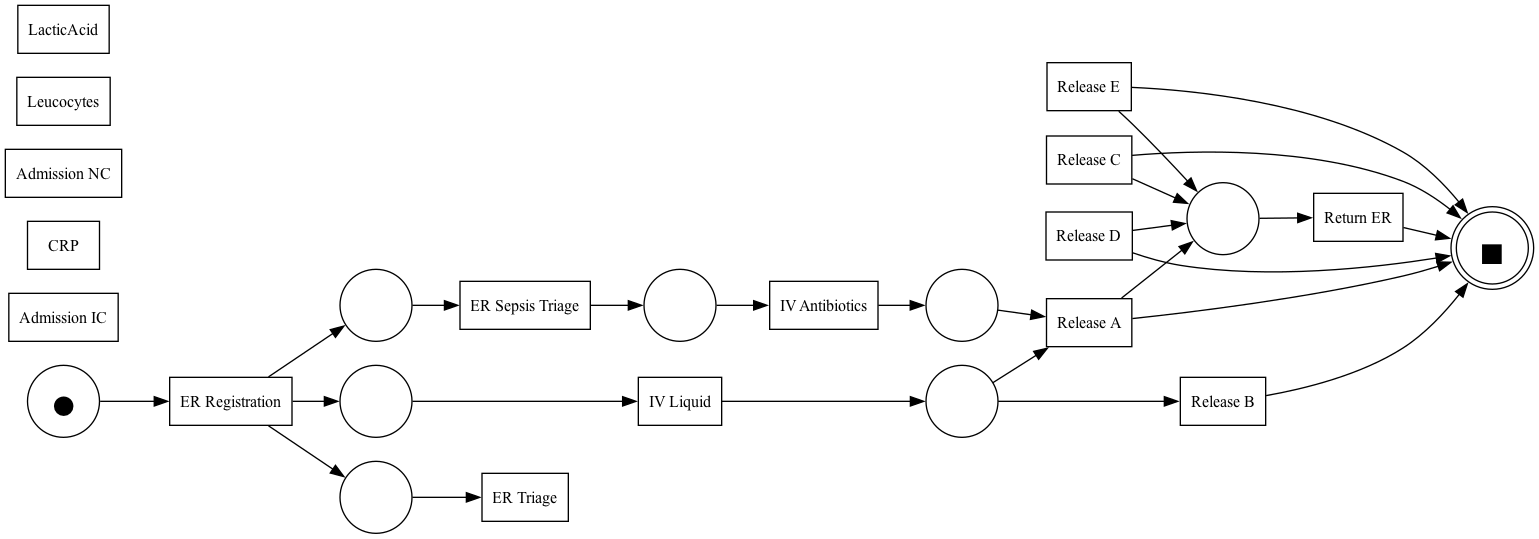

''

In [18]:
wfnet_alpha = pm4py.discover_petri_net_alpha(log)
pm4py.vis.view_petri_net(*wfnet_alpha)
pm4py.vis.save_vis_petri_net(*wfnet_alpha, "images/basic_petri_net.pdf")

In [19]:
from pm4py.algo.analysis.woflan import algorithm as woflan

woflan_parameters = {
    woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND: False,
    woflan.Parameters.PRINT_DIAGNOSTICS: True,
    woflan.Parameters.RETURN_DIAGNOSTICS: False
}

is_sound = woflan.apply(*wfnet_alpha, parameters=woflan_parameters)
print(f"Is sound: {is_sound}")

Input is ok.
Petri Net is a not a worflow net.
Is sound: False


/var/folders/cp/w6zb81516yz3b7dw7m2sgt_80000gn/T/ipykernel_2645/3673715517.py:1: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. this method will be removed in a future release.
  wfnet_alphap = pm4py.discover_petri_net_alpha_plus(log)


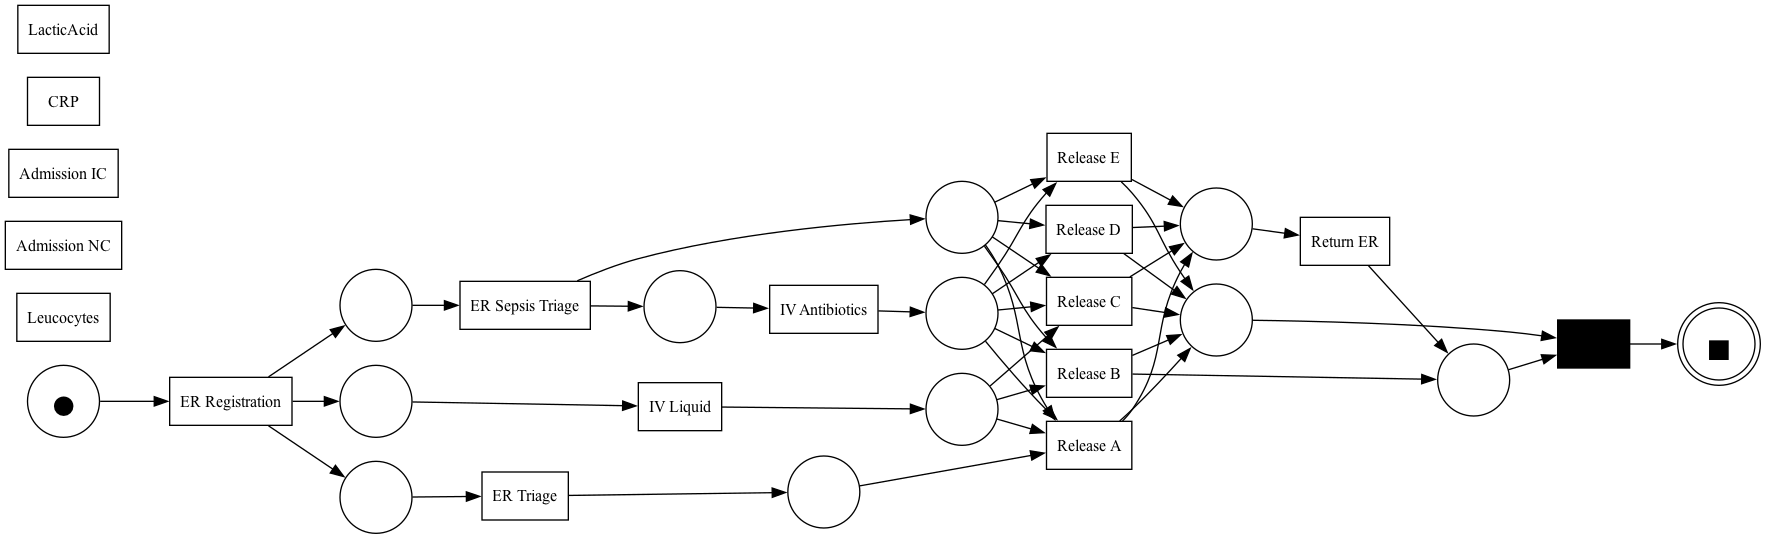

''

In [20]:
wfnet_alphap = pm4py.discover_petri_net_alpha_plus(log)
pm4py.vis.view_petri_net(*wfnet_alphap)
pm4py.vis.save_vis_petri_net(*wfnet_alphap, "images/alpha_plus_petri_net.pdf")

In [21]:
is_sound = woflan.apply(*wfnet_alphap, parameters=woflan_parameters)
print(f"Is sound: {is_sound}")

Input is ok.
Petri Net is a not a worflow net.
Is sound: False


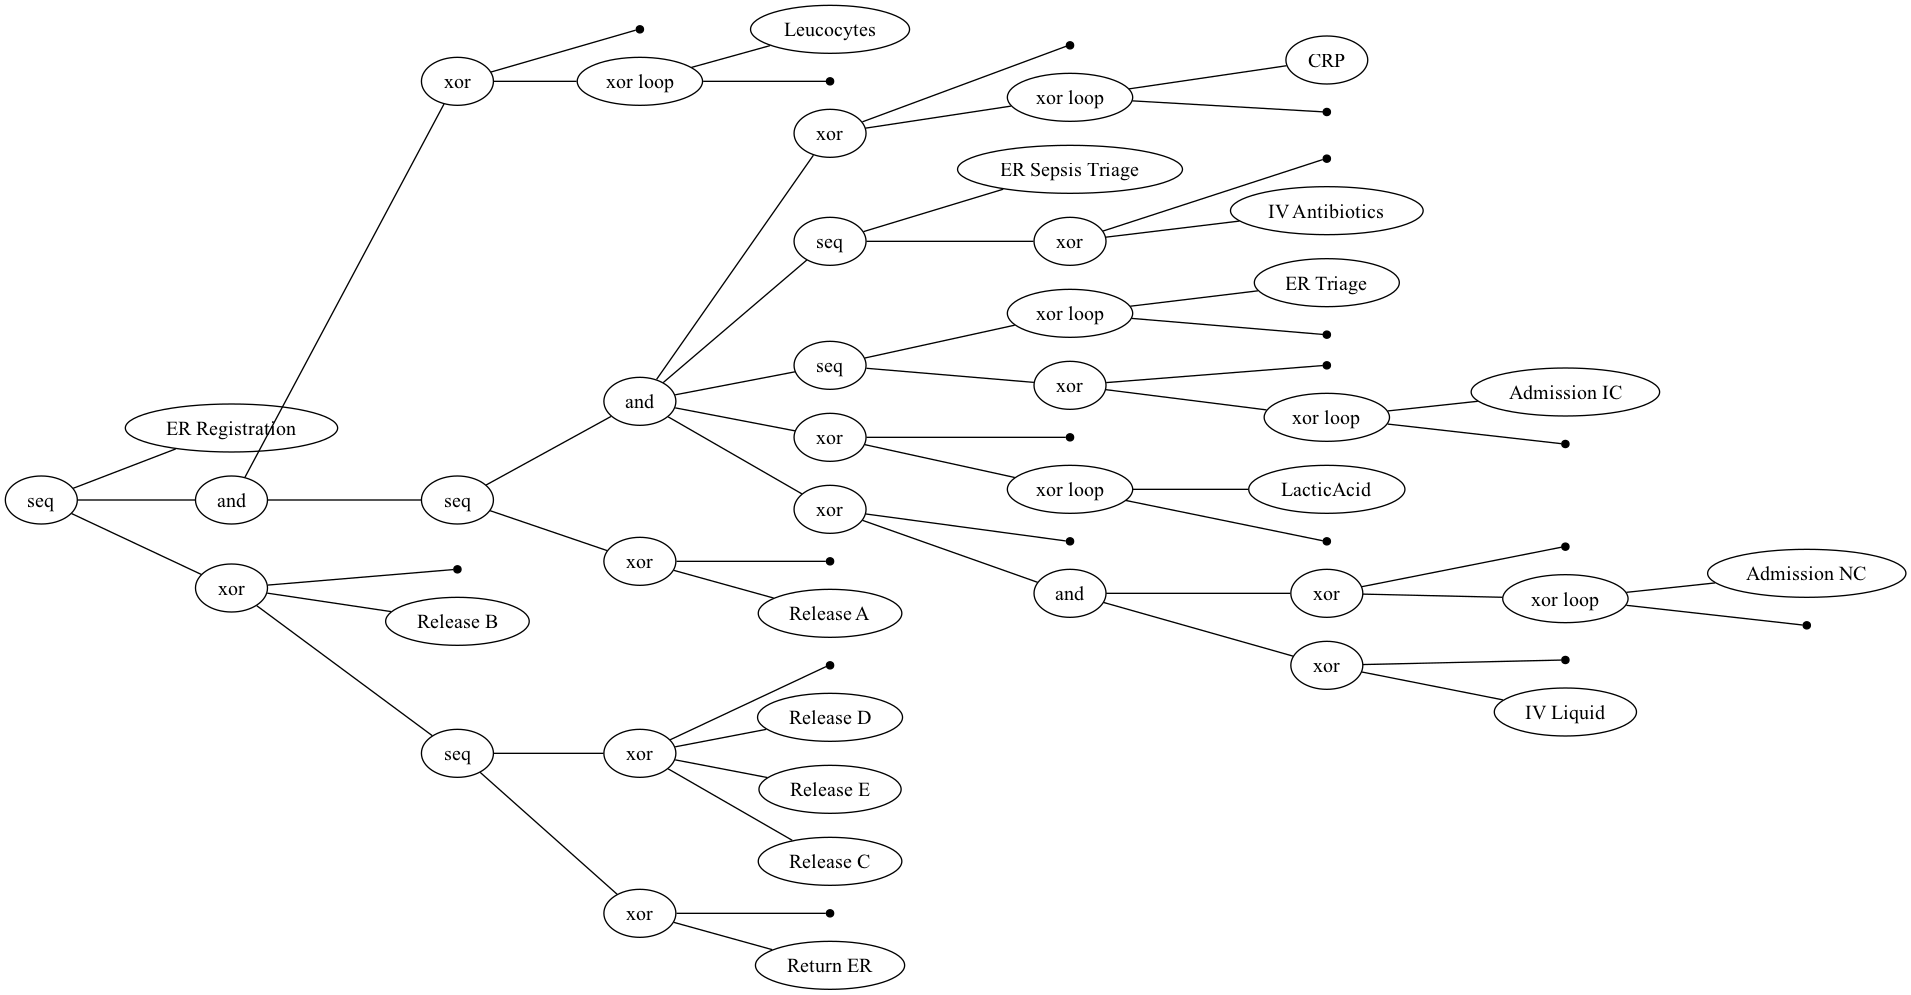

''

In [22]:
treenet_ind = pm4py.discover_process_tree_inductive(log)
pm4py.vis.view_process_tree(treenet_ind)
pm4py.vis.save_vis_process_tree(treenet_ind, "images/inductive_process_tree.pdf")

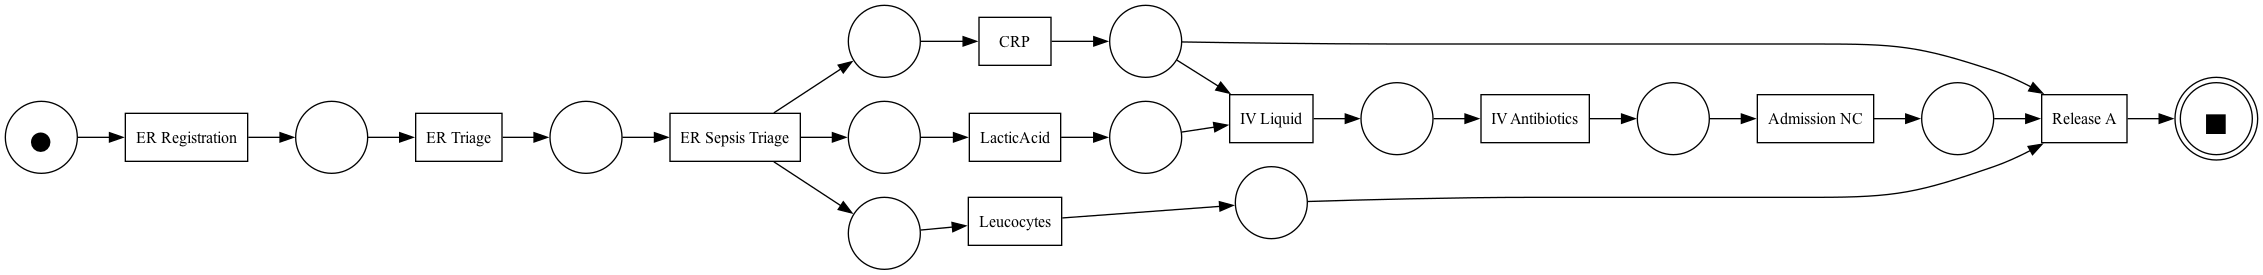

In [23]:
k=5
log_top_k = pm4py.filter_variants_top_k(log, k)
wfnet_alphap_topk = pm4py.discover_petri_net_alpha(log_top_k)
pm4py.vis.view_petri_net(*wfnet_alphap_topk)

In [24]:
is_sound = woflan.apply(*wfnet_alphap_topk, parameters=woflan_parameters)
print(f"Is sound: {is_sound}")

Input is ok.
Petri Net is a workflow net.
The following places are not covered by an s-component: [({'CRP'}, {'IV Liquid', 'Release A'}), ({'ER Sepsis Triage'}, {'CRP'})].


/opt/anaconda3/envs/procmin/lib/python3.12/site-packages/pm4py/algo/analysis/woflan/place_invariants/utility.py:153: UserWarning: solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.
  warnings.warn("solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.")


Not well-handled pairs are: [(39, 14), (39, 20)].
The following places are uncovered in uniform invariants: [({'CRP'}, {'IV Liquid', 'Release A'}), ({'ER Sepsis Triage'}, {'CRP'})]
The following places are uncovered in weighted invariants: [({'CRP'}, {'IV Liquid', 'Release A'}), ({'ER Sepsis Triage'}, {'CRP'})]
No improper conditions.
The following tasks are dead: [(Release A, 'Release A'), (short_circuited_transition, 'short_circuited_transition')]
Is sound: False


,variant,count,percentile
122,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, Admission NC, Release A)",5,0.68
48,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes, Admission NC, Release A)",4,0.54
183,"(ER Registration, ER Triage, ER Sepsis Triage, LacticAcid, Leucocytes, CRP, IV Liquid, IV Antibiotics, Admission NC, Release A)",4,0.54


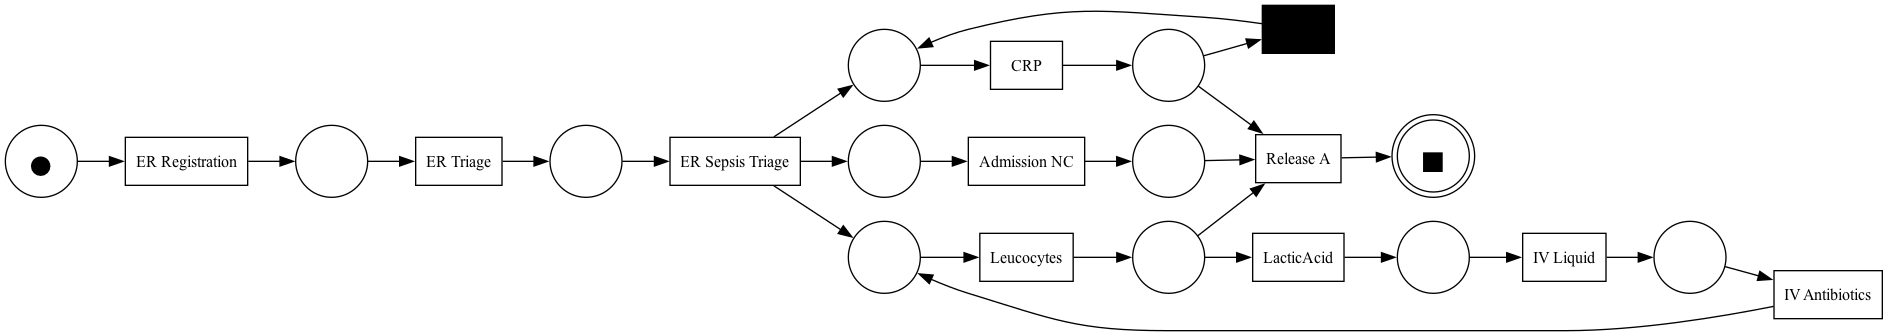

Input is ok.
Petri Net is a workflow net.
Every place is covered by s-components.
There are no dead tasks.
All tasks are live.
Is sound: True


/opt/anaconda3/envs/procmin/lib/python3.12/site-packages/pm4py/algo/analysis/woflan/place_invariants/utility.py:153: UserWarning: solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.
  warnings.warn("solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.")


In [25]:
k = 3 # top-k variants
display(common_variants[0:k])

log_top_k = pm4py.filter_variants_top_k(log, k)

wfnet_inductive = pm4py.discover_petri_net_inductive(log_top_k)
pm4py.vis.view_petri_net(*wfnet_inductive)
pm4py.vis.save_vis_petri_net(*wfnet_inductive, "images/final_inductive_petri_net.pdf")

is_sound = woflan.apply(*wfnet_inductive, parameters=woflan_parameters)
print(f"Is sound: {is_sound}")

/opt/anaconda3/envs/procmin/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:00<00:00, 1020.48it/s]


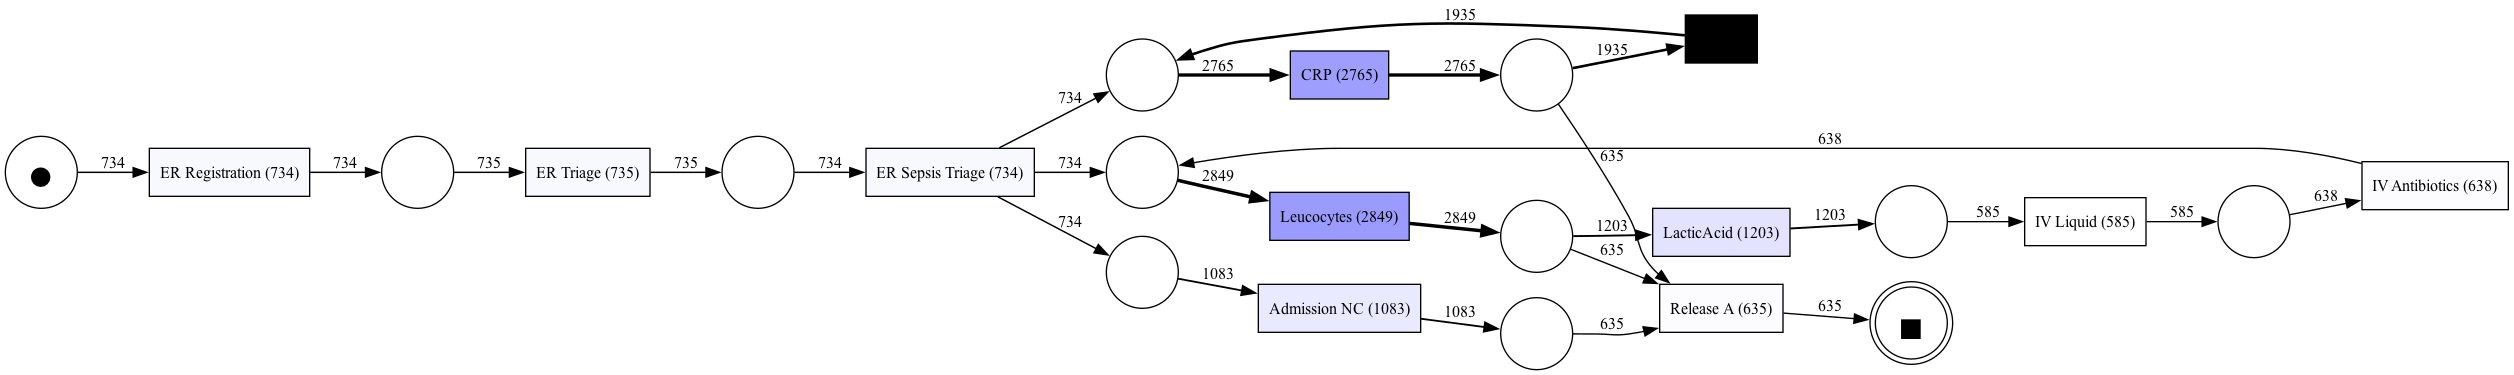

replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:00<00:00, 1135.96it/s]


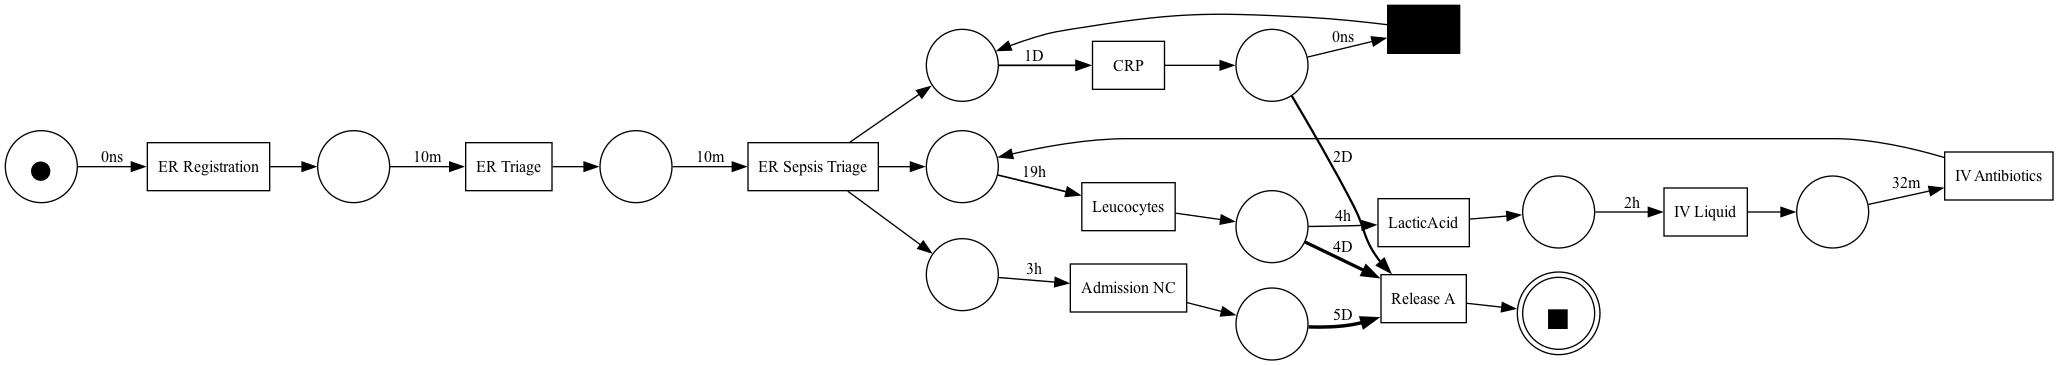

replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:00<00:00, 1098.06it/s]


''

In [26]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

net = wfnet_inductive

# add frequencies
parameters_freq = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz_freq = pn_visualizer.apply(*net, parameters=parameters_freq, variant=pn_visualizer.Variants.FREQUENCY, log=log)
pn_visualizer.view(gviz_freq)

# To save as pdf
parameters_freq = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "pdf"}
gviz_freq = pn_visualizer.apply(*net, parameters=parameters_freq, variant=pn_visualizer.Variants.FREQUENCY, log=log)
pn_visualizer.save(gviz_freq, "images/wf_freq.pdf")

# add temporal information
parameters_temp = {pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT: "png"}
gviz_temp = pn_visualizer.apply(*net, parameters=parameters_temp, variant=pn_visualizer.Variants.PERFORMANCE, log=log)
pn_visualizer.view(gviz_temp)

# To save as pdf
parameters_temp = {pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT: "pdf"}
gviz_temp = pn_visualizer.apply(*net, parameters=parameters_temp, variant=pn_visualizer.Variants.PERFORMANCE, log=log)
pn_visualizer.save(gviz_temp, "images/wf_temporal.pdf")

### Calculate metrics

In [27]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

net = wfnet_inductive

fitness = pm4py.fitness_alignments(log, *net)
precision = pm4py.precision_alignments(log, *net)
generalization = generalization_evaluator.apply(log, *net)
simplicity = simplicity_evaluator.apply(net[0])

aligning log, completed variants :: 100%|██████████| 685/685 [00:07<00:00, 86.77it/s] 
computing precision with alignments, completed variants :: 100%|██████████| 5115/5115 [00:09<00:00, 550.46it/s]
replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:00<00:00, 1176.28it/s]


In [28]:
pd.DataFrame({"Average Fitness": [fitness["averageFitness"]],
              "Precision": [precision],
              "Generalization": [generalization],
              "Simplicity": [simplicity]})

,Average Fitness,Precision,Generalization,Simplicity
0,0.77,0.93,0.97,0.79


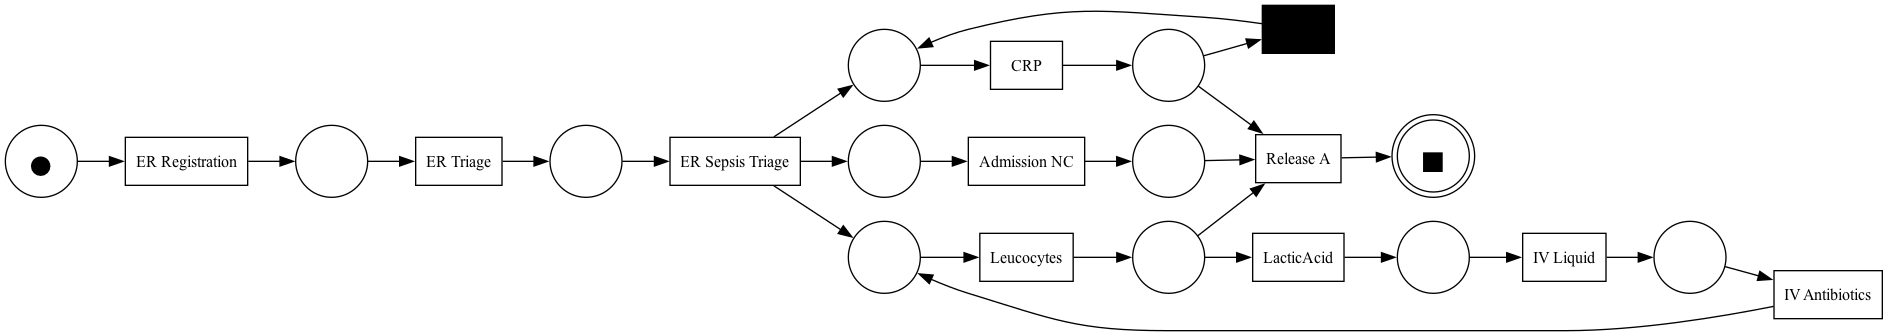

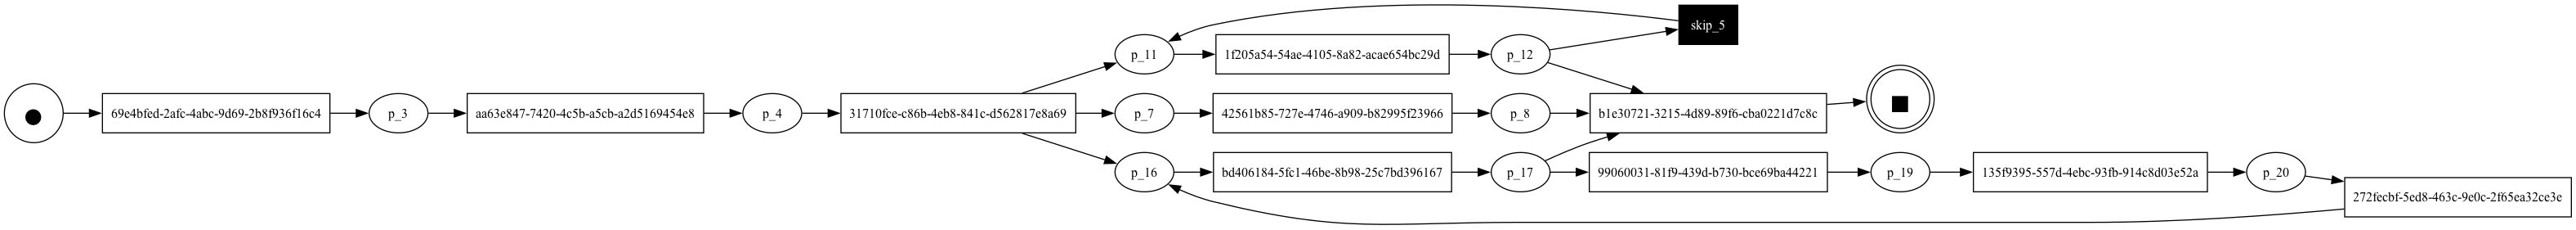

{'p_12': ['skip_5', 'b1e30721-3215-4d89-89f6-cba0221d7c8c'], 'p_17': ['99060031-81f9-439d-b730-bce69ba44221', 'b1e30721-3215-4d89-89f6-cba0221d7c8c']}


replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:00<00:00, 1035.56it/s]


Decision point: p_12; possible decisions: ['skip_5', 'Release A', 'None']


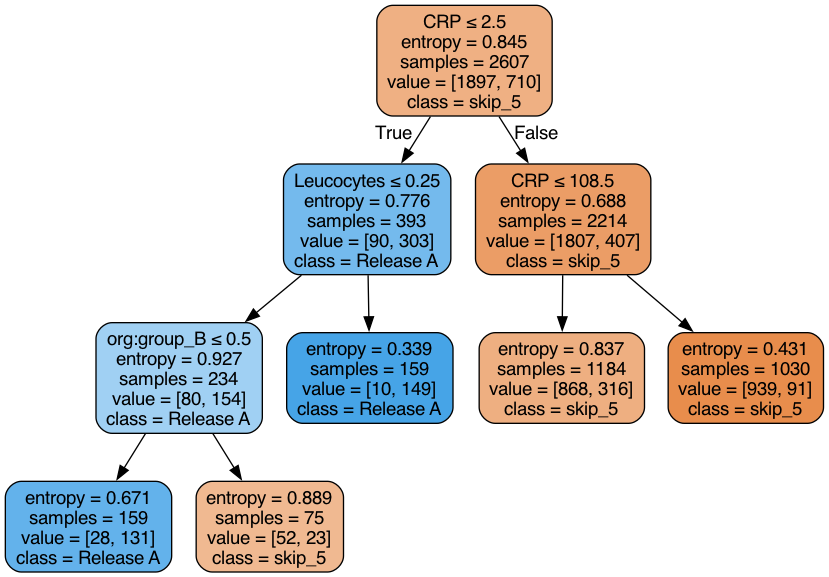

replaying log with TBR, completed traces :: 100%|██████████| 685/685 [00:00<00:00, 1060.04it/s]


Decision point: p_17; possible decisions: ['LacticAcid', 'Release A']


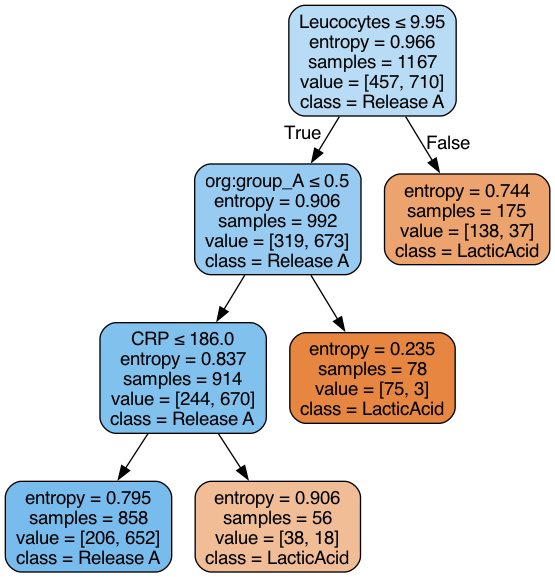

In [34]:
from pm4py.algo.decision_mining import algorithm as decision_mining
from pm4py.visualization.petri_net import visualizer
from pm4py.visualization.decisiontree import visualizer as tree_visualizer
from sklearn import tree

net = wfnet_inductive

# View the WF-net
pm4py.view_petri_net(*net)
# View the identifiers of the nodes in the WF-net
gviz = visualizer.apply(*net, parameters={visualizer.Variants.WO_DECORATION.value.Parameters.DEBUG: True})
visualizer.view(gviz)
attributes = pm4py.get_event_attributes(log)
attributes = [att for att in attributes if "time" not in att]

decision_points = decision_mining.get_decision_points(net[0])
print(decision_points)
for point in sorted(decision_points.keys()):
  X, y, classes = decision_mining.apply(log, *net, decision_point=point, attributes=attributes,)
  X = X.fillna(0)
  X = X[~y.isna()]
  y = y[~y.isna()]
  classes = [str(c) for c in classes]

  print(f"Decision point: {point}; possible decisions: {classes}")

  dt = tree.DecisionTreeClassifier(max_depth=3, ccp_alpha=0.01,
                                   random_state=42, criterion="entropy")
  dt = dt.fit(X, y)
  feature_names = list(X.columns.values.tolist())

  gviz = tree_visualizer.apply(dt, feature_names, classes)
  tree_visualizer.view(gviz)
  # Save in pdf
  gviz = tree_visualizer.apply(dt, feature_names, classes,
                               parameters={visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "pdf"})
  tree_visualizer.save(gviz, f"images/decision_tree_{point}.pdf")
